<a href="https://colab.research.google.com/github/willystw/fastai-learning/blob/shelter-animal/shelter-animal/Shelter_Animal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#hide
!pip install -Uqq fastbook waterfallcharts treeinterpreter dtreeviz
!pip install --upgrade --force-reinstall --no-deps kaggle
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 720 kB 4.2 MB/s 
     |████████████████████████████████| 61 kB 563 kB/s 
     |████████████████████████████████| 1.2 MB 30.8 MB/s 
     |████████████████████████████████| 186 kB 48.7 MB/s 
     |████████████████████████████████| 46 kB 4.6 MB/s 
     |████████████████████████████████| 56 kB 4.1 MB/s 
     |████████████████████████████████| 51 kB 324 kB/s 
     |████████████████████████████████| 58 kB 2.5 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=3453dbb9b2e866454fe1d90ec2389e6ecf71997dd3ac2249cf915157ca5f0a58
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12
Mounted at /content/gdrive


In [2]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

rm: cannot remove '/root/.kaggle': No such file or directory


In [27]:
#hide
from fastbook import *
from kaggle import api
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import zipfile, gzip

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

In [35]:
!rm -r ~/shelter-animal-outcomes
!mkdir ~/shelter-animal-outcomes
    
api.competition_download_cli('shelter-animal-outcomes', path='shelter-animal-outcomes')

with zipfile.ZipFile('shelter-animal-outcomes/shelter-animal-outcomes.zip','r') as zip_ref:
    zip_ref.extractall('data')

with gzip.open('data/sample_submission.csv.gz') as f:
    sample_submission = pd.read_csv(f)

with gzip.open('data/test.csv.gz') as f:
    test = pd.read_csv(f)

with gzip.open('data/train.csv.gz') as f:
    train = pd.read_csv(f, low_memory=False)


shelter-animal-outcomes.zip: Skipping, found more recently modified local copy (use --force to force download)


In [36]:
sample_submission.head()

,ID,Adoption,Died,Euthanasia,Return_to_owner,Transfer
0,1,1,0,0,0,0
1,2,1,0,0,0,0
2,3,1,0,0,0,0
3,4,1,0,0,0,0
4,5,1,0,0,0,0


In [37]:
test.head()

,ID,Name,DateTime,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,1,Summer,2015-10-12 12:15:00,Dog,Intact Female,10 months,Labrador Retriever Mix,Red/White
1,2,Cheyenne,2014-07-26 17:59:00,Dog,Spayed Female,2 years,German Shepherd/Siberian Husky,Black/Tan
2,3,Gus,2016-01-13 12:20:00,Cat,Neutered Male,1 year,Domestic Shorthair Mix,Brown Tabby
3,4,Pongo,2013-12-28 18:12:00,Dog,Intact Male,4 months,Collie Smooth Mix,Tricolor
4,5,Skooter,2015-09-24 17:59:00,Dog,Neutered Male,2 years,Miniature Poodle Mix,White


In [38]:
train.head()

,AnimalID,Name,DateTime,OutcomeType,...,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,...,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,...,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,...,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,...,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,...,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


In [47]:
train = add_datepart(train, 'DateTime')


KeyError: ignored

In [48]:
test = add_datepart(test,'DateTime')

In [52]:
dep_var = 'OutcomeType'

In [62]:
cont, cat = cont_cat_split(train, 1 , dep_var)

In [55]:
procs = [Categorify]

In [64]:
train_tabular = TabularPandas(train, procs, cat, cont, y_names=dep_var, splits=RandomSplitter(valid_pct=0.2)(range_of(train)))

In [65]:
xs,y = train_tabular.train.xs, train_tabular.train.y

valid_x,valid_y = train_tabular.valid.xs, train_tabular.valid.y

In [67]:
len(train_tabular.train), len(train_tabular.valid)

(21384, 5345)

In [68]:
def rf(xs, y, n_estimators=30, max_samples=10_000,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [69]:
m = rf(xs, y)

In [70]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [77]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [93]:
xs_drop = xs.drop(['OutcomeSubtype'], axis=1)
valid_x_drop = valid_x.drop(['OutcomeSubtype'], axis=1)

In [94]:
m = rf(xs_drop, y)

In [95]:
fi = rf_feat_importance(m, xs_drop)

In [96]:
m_rmse(m, xs_drop, y), m_rmse(m, valid_x_drop, valid_y)

(1.166625, 1.396225)

In [97]:
r_mse(m.oob_prediction_, y)

1.417721

In [100]:
to_keep = fi[fi.imp>0.005].cols
len(to_keep)

13

In [105]:
xs_imp = xs_drop[to_keep]
valid_x_imp = valid_x_drop[to_keep]

In [107]:
m = rf(xs_imp, y)

In [108]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

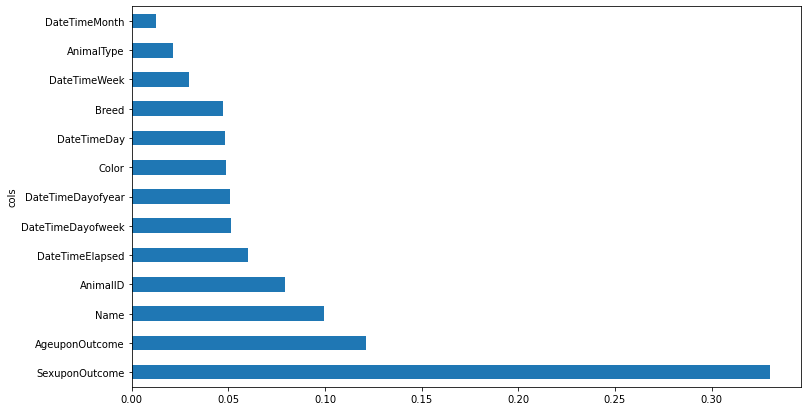

In [109]:
plot_fi(rf_feat_importance(m, xs_imp));

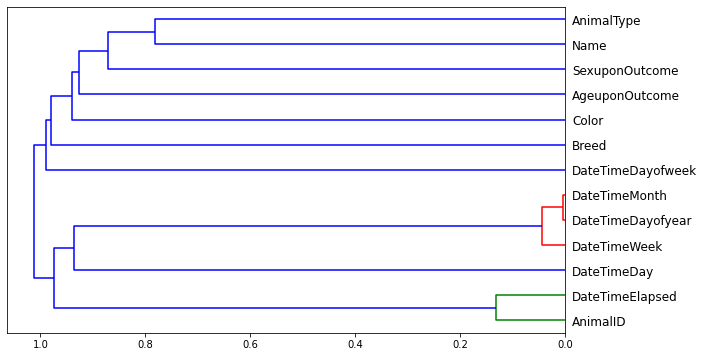

In [110]:
cluster_columns(xs_imp)

In [113]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=15,
        max_samples=5000, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(df, y)
    return m.oob_score_

In [114]:
get_oob(xs_imp)

0.3579844642057679

In [117]:
{c:get_oob(xs_imp.drop(c, axis=1)) for c in (
    'DateTimeMonth', 'DateTimeDayofyear')}

{'DateTimeDayofyear': 0.360972951144495, 'DateTimeMonth': 0.36215624788099876}

In [118]:
to_drop = ['DateTimeMonth']
get_oob(xs_imp.drop(to_drop, axis=1))

0.3587726390380742

In [120]:
xs_final = xs_imp.drop(to_drop, axis=1)
valid_x_final = valid_x_imp.drop(to_drop, axis=1)

In [121]:
df_dom = pd.concat([xs_final, valid_x_final])
is_valid = np.array([0]*len(xs_final) + [1]*len(valid_x_final))

m = rf(df_dom, is_valid)
rf_feat_importance(m, df_dom)[:6]

,cols,imp
3,AnimalID,0.153119
4,DateTimeElapsed,0.131387
2,Name,0.124647
8,Color,0.111052
7,DateTimeDayofyear,0.085748
1,AgeuponOutcome,0.085235


In [123]:
m = rf(xs_final, y)
print('orig', m_rmse(m, valid_x_final, valid_y))

for c in ('AnimalID','DateTimeElapsed','Name'):
    m = rf(xs_final.drop(c,axis=1), y)
    print(c, m_rmse(m, valid_x_final.drop(c,axis=1), valid_y))

orig 1.392365
AnimalID 1.407302
DateTimeElapsed 1.403504
Name 1.391722


In [126]:
time_vars = ['AnimalID','Name']
xs_final_time = xs_final.drop(time_vars, axis=1)
valid_x_time = valid_x_final.drop(time_vars, axis=1)

In [128]:
m = rf(xs_final_time, y)
m_rmse(m, valid_x_time, valid_y)

1.402594

In [132]:
cont, cat

(['DateTimeYear',
  'DateTimeMonth',
  'DateTimeWeek',
  'DateTimeDay',
  'DateTimeDayofweek',
  'DateTimeDayofyear',
  'DateTimeElapsed'],
 ['AnimalID',
  'Name',
  'OutcomeSubtype',
  'AnimalType',
  'SexuponOutcome',
  'AgeuponOutcome',
  'Breed',
  'Color',
  'DateTimeIs_month_end',
  'DateTimeIs_month_start',
  'DateTimeIs_quarter_end',
  'DateTimeIs_quarter_start',
  'DateTimeIs_year_end',
  'DateTimeIs_year_start'])

## Neural Network

In [134]:
with gzip.open('data/train.csv.gz') as f:
    train_nn = pd.read_csv(f, low_memory=False)

train_nn = add_datepart(train_nn, 'DateTime')

In [136]:
train_nn_final = train_nn[list(xs_final_time.columns) + [dep_var]]

In [137]:
cont_nn,cat_nn = cont_cat_split(train_nn_final, max_card=2000, dep_var=dep_var)

In [138]:
cont_nn, cat_nn

(['DateTimeElapsed'],
 ['SexuponOutcome',
  'AgeuponOutcome',
  'DateTimeDay',
  'DateTimeDayofweek',
  'DateTimeDayofyear',
  'Color',
  'Breed',
  'DateTimeWeek',
  'AnimalType'])

In [139]:
train_nn_final[cat_nn].nunique()

SexuponOutcome          5
AgeuponOutcome         44
DateTimeDay            31
DateTimeDayofweek       7
DateTimeDayofyear     365
Color                 366
Breed                1380
DateTimeWeek           53
AnimalType              2
dtype: int64

In [140]:
procs_nn = [Categorify, Normalize]
to_nn = TabularPandas(train_nn_final, procs_nn, cat_nn, cont_nn,
                      splits=RandomSplitter(valid_pct=0.2)(range_of(train)), y_names=dep_var)

In [142]:
dls = to_nn.dataloaders(256)

In [160]:
to_nn.valid

       SexuponOutcome  AgeuponOutcome  DateTimeElapsed  DateTimeDay  ...  \
11494               3              35        -1.671855           30  ...   
8951                3              27         0.537631            1  ...   
13832               4              20         1.493744           24  ...   
13974               3               6        -0.118486           19  ...   
25946               1              21         0.635067           25  ...   
...               ...             ...              ...          ...  ...   
15661               4               6         1.473757           19  ...   
25540               4              42         1.565811           11  ...   
15300               2              12        -0.029801           11  ...   
13120               4              38        -0.518409           12  ...   
20443               4               3        -0.308072            3  ...   

       Breed  DateTimeWeek  AnimalType  OutcomeType  
11494    756            44       

In [143]:
y = to_nn.train.y
y.min(),y.max()

(0, 4)

In [200]:
class MyCrossEntropy(nn.CrossEntropyLoss):
  
  def forward(self, input, target):
    target = target.long()
    return F.cross_entropy(input, target, weight=self.weight, ignore_index=self.ignore_index, reduction=self.reduction)

In [201]:
learn = tabular_learner(dls, layers=[100,50], loss_func= MyCrossEntropy())

In [202]:
learn.lr_find()

RuntimeError: ignored